<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
df_age = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df_age.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
df_age.median()

real_age    29.0
dtype: float64

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

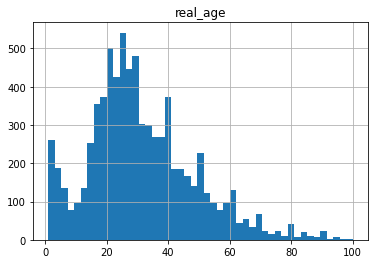

In [6]:
df_age.hist(bins = 'auto')

__Заметка__

- В выборке медианный возраст составляет 29 лет, средний - 31 год;
- Меньше всего представлены подростки. На то могут быть причины, например подростки одного и того же возраста могут выглядеть по-разному. Догадываюсь, что специально оставлен "типовой вид" подростков, а шумы в виде "подростков-переростков" удалены. В любом случае меньшее количество подростков в обучающей выборке играет не в пользу задачи бизнеса по контролю "добросовестности кассиров при продаже алкоголя". Стоит над этим задуматься.

Из фотографий в папках класс ImageDataGenerator формирует батчи с изображениями и метками классов. Создадим его:

In [7]:
datagen = ImageDataGenerator(rescale=1 / 255)

Чтобы загрузчик извлёк данные из папки, вызовем функцию flow_from_directory() (англ. «поток из директории»):

In [8]:
train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = df_age,
        directory = '/datasets/faces/final_files/', # папка, в которой хранится датасет
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),  # к какому размеру приводить изображения
        batch_size = 16,  # размер батча`
        class_mode = 'raw',  # в каком виде выдавать метки классов
        #subset='training', 
        seed=12345) # фиксируем генератор случайных чисел (от англ. random seed)

Found 7591 validated image filenames.


Загрузчик нашёл 1 класс (папку), всего в них 7591 изображений.

Пары «картинки — метки» можно получить функцией next() (англ. «следующий»):

In [9]:
features, target = next(train_datagen_flow)
print(features.shape) 

(16, 150, 150, 3)


Получили признаки — четырёхмерный тензор, в котором 16 изображений размером 150x150 с тремя цветовыми каналами.

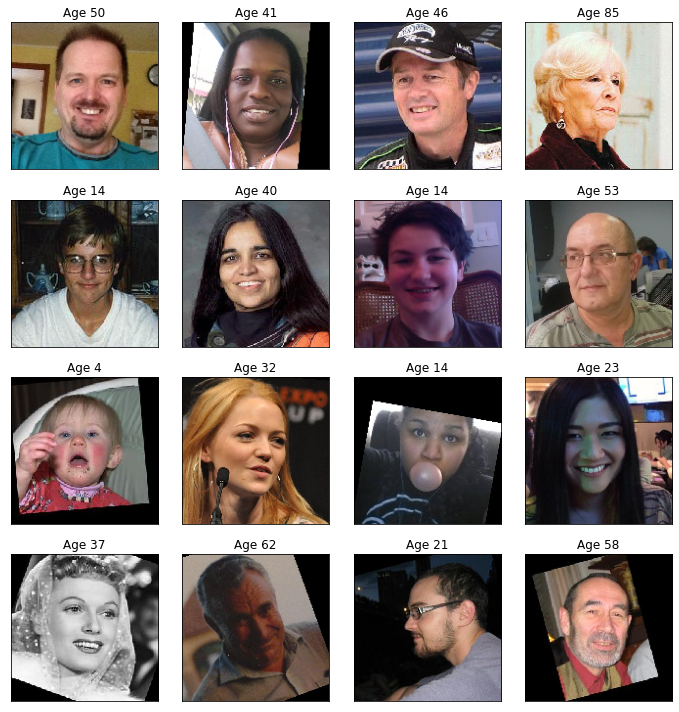

In [10]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title(f'Age {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

__Заметка__

- В выборке имеются как цветные, так и черно-белые фотографии
- Имеются фотографии "под углом"
- Есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев
- В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев

## Обучение модели

<div class="alert alert-block alert-success">
<b>Внимание:</b> Код в этом разделе запускается в отдельном GPU-тренажёре Yandex Cloud, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)
</div>

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='relu'))
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/6
2022-08-21 11:15:05.065632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-21 11:15:05.589578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 70s - loss: 194.6139 - mae: 10.2710 - val_loss: 473.0858 - val_mae: 16.5087
Epoch 2/6
356/356 - 52s - loss: 97.7630 - mae: 7.5268 - val_loss: 157.7034 - val_mae: 9.6714
Epoch 3/6
356/356 - 43s - loss: 73.4645 - mae: 6.5403 - val_loss: 93.9788 - val_mae: 7.2897
Epoch 4/6
356/356 - 40s - loss: 57.3244 - mae: 5.7731 - val_loss: 106.0344 - val_mae: 7.7669
Epoch 5/6
356/356 - 40s - loss: 44.9233 - mae: 5.1136 - val_loss: 75.8822 - val_mae: 6.5384
Epoch 6/6
356/356 - 44s - loss: 32.1241 - mae: 4.3958 - val_loss: 70.8871 - val_mae: 6.2013
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 70.8871 - mae: 6.2013
Test MAE: 6.2013

```

## Анализ обученной модели

В выборке медианный возраст составляет 29 лет, средний - 31 год. Меньше всего представлены подростки. На то могут быть причины, например подростки одного и того же возраста могут выглядеть по-разному. Догадываюсь, что специально оставлен "типовой вид" подростков, а шумы в виде "подростков-переростков" удалены. В любом случае меньшее количество подростков в обучающей выборке играет не в пользу задачи бизнеса по контролю "добросовестности кассиров при продаже алкоголя".

По результатам многочисленных пересчетов на мощностях Yandex Cloud удалось достигнуть MAE 6.2 года, при критерии в семь лет. Что же это нам дает? Наша модель может определить с ошибкой в +/- шесть лет возраст покупателя. Eсли возраст покупателя определяется младше 25 лет, то можно смело чекать видео продажи кассира или чек покупателя на предмет наличия запрещенных до 18 лет товаров. С точки зрения покупательской корзины тоже достаточно приемлемо, можем разделить покупателей на классы и предлагать дополнительные товары.

ps дополнительное изменение угла не дало результатов по метрике